# **Tomato Leaf Disease Classification**

Dataset used: https://www.kaggle.com/datasets/arjuntejaswi/plant-village

### **Loading the module and datas**

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [2]:
#constants
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS   = 3
FILE_PATH  = "TomatoLeafTraining"

In [ ]:
#copying only the necessary datasets
!mkdir "PlantVillage"
!cp -r "../input/plant-village/PlantVillage/Tomato_Bacterial_spot/" "/kaggle/working/PlantVillage"
!cp -r "../input/plant-village/PlantVillage/Tomato_Early_blight/" "/kaggle/working/PlantVillage"
!cp -r "../input/plant-village/PlantVillage/Tomato_Late_blight/" "/kaggle/working/PlantVillage"
!cp -r "../input/plant-village/PlantVillage/Tomato_Leaf_Mold/" "/kaggle/working/PlantVillage"
!cp -r "../input/plant-village/PlantVillage/Tomato_Spider_mites_Two_spotted_spider_mite/" "/kaggle/working/PlantVillage"
!cp -r "../input/plant-village/PlantVillage/Tomato__Target_Spot/" "/kaggle/working/PlantVillage"
!cp -r "../input/plant-village/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/" "/kaggle/working/PlantVillage"
!cp -r "../input/plant-village/PlantVillage/Tomato__Tomato_mosaic_virus/" "/kaggle/working/PlantVillage"
!cp -r "../input/plant-village/PlantVillage/Tomato_healthy/" "/kaggle/working/PlantVillage"



In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
            directory=FILE_PATH,
            shuffle=True,
            image_size=(IMAGE_SIZE,IMAGE_SIZE),
            batch_size = BATCH_SIZE,
)

Found 14400 files belonging to 10 classes.


In [4]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Healthy',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Mosaic_Virus',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato_Target_Spot',
 'Tomato_Yellow_Leaf_Curl_Virus']

In [5]:
len(class_names)

10

### **Data Visualization**

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 5 8 6 7 9 1 7 7 6 8 0 3 8 9 2 0 9 4 5 7 4 8 0 2 9 4 0 3 9 2 8]


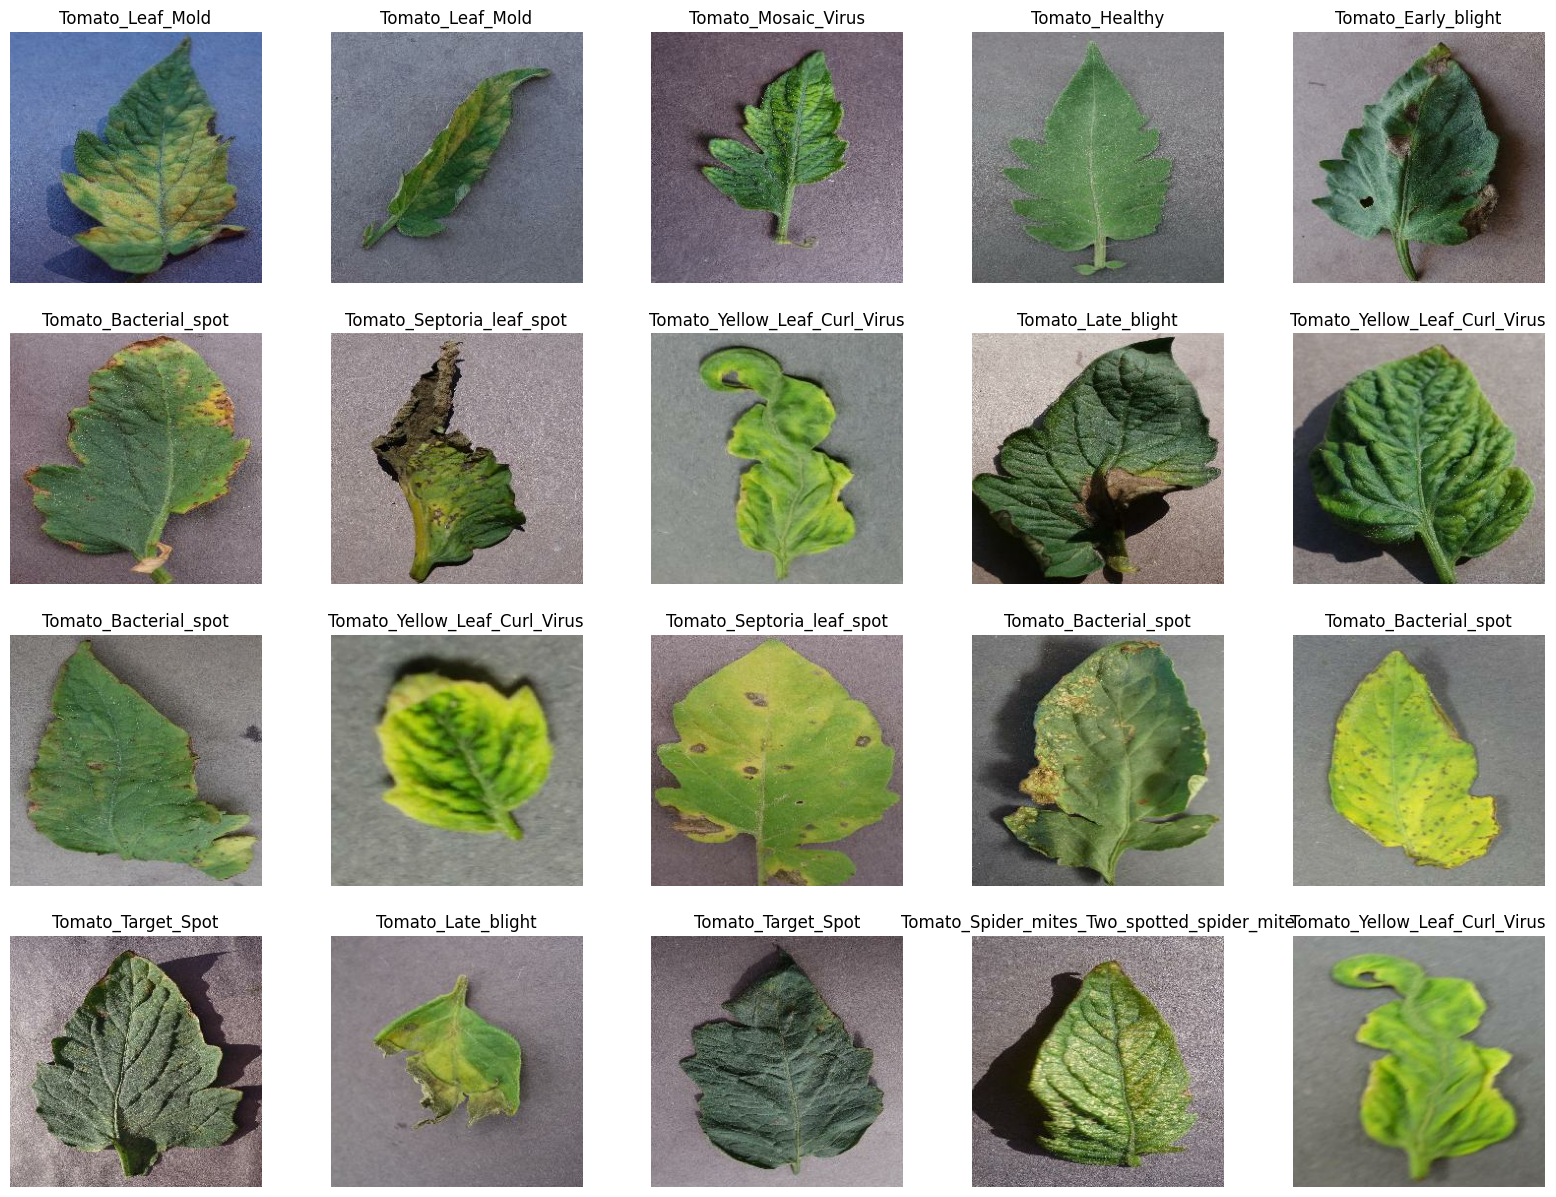

In [8]:
plt.figure(figsize=(20,15))
for image_batch, label_batch in dataset.take(1):
    for i in range(20):
        ax = plt.subplot(4,5,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

### **Train Test Split**

In [9]:
def get_dataset_partitions(ds,train_split=0.8,test_split=0.1,valid_split=0.1,shuffle=True,shuffle_size=10000):
    assert  train_split+test_split+valid_split==1
    ds_size = len(ds)
    if shuffle:
        ds.shuffle(shuffle_size,seed=12)
    train_size = int(len(ds)*train_split)
    valid_size = int(len(ds)*valid_split)

  
    train_ds = ds.take(train_size)    
    valid_ds = ds.skip(train_size).take(valid_size)
    test_ds = ds.skip(train_size).skip(valid_size)
    
    return train_ds ,test_ds, valid_ds
    

In [10]:
train_ds ,test_ds, valid_ds = get_dataset_partitions(dataset)
    

In [11]:
print(len(train_ds))
print(len(test_ds))
print(len(valid_ds))

360
45
45


In [12]:
# performance improving by both using CPU and GPU
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### **Image Preprocessing**

In [13]:
rescale_and_resize=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE) ,# will resize to the IMAGE_SIZE if there's any issue
    layers.experimental.preprocessing.Rescaling(1./255)  # Normalization
])

In [14]:
#data augmentation

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

### **Building a Model**

In [15]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)


model = models.Sequential([
    rescale_and_resize,
    data_augmentation,
    
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [17]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [18]:
EPOCHS = 20

In [19]:

if 'history' not in locals():
    history = []
#model training
history.append(
    model.fit(
        train_ds,
        batch_size=BATCH_SIZE,
        validation_data=valid_ds,
        verbose=1,
        epochs=EPOCHS
    )
)

Epoch 1/20
360/360 [==============================] - 1866s 5s/step - loss: 1.6460 - accuracy: 0.4160 - val_loss: 1.2953 - val_accuracy: 0.5646
Epoch 2/20
360/360 [==============================] - 1563s 4s/step - loss: 0.9398 - accuracy: 0.6825 - val_loss: 1.1568 - val_accuracy: 0.6042
Epoch 3/20
360/360 [==============================] - 1559s 4s/step - loss: 0.6880 - accuracy: 0.7608 - val_loss: 0.9387 - val_accuracy: 0.6681
Epoch 4/20
360/360 [==============================] - 1820s 5s/step - loss: 0.5316 - accuracy: 0.8101 - val_loss: 0.8017 - val_accuracy: 0.7222
Epoch 5/20
360/360 [==============================] - 1352s 4s/step - loss: 0.4491 - accuracy: 0.8403 - val_loss: 0.7405 - val_accuracy: 0.7521
Epoch 6/20
360/360 [==============================] - 1423s 4s/step - loss: 0.3859 - accuracy: 0.8657 - val_loss: 0.7695 - val_accuracy: 0.7410
Epoch 7/20
360/360 [==============================] - 1408s 4s/step - loss: 0.3434 - accuracy: 0.8800 - val_loss: 0.8692 - val_accuracy:

In [20]:
scores = model.evaluate(test_ds)
scores

45/45 [==============================] - 256s 706ms/step - loss: 0.3824 - accuracy: 0.8806


[0.3824061155319214, 0.8805555701255798]

### **Plotting Model Accuracy**

In [21]:
acc = []
val_acc = []
loss = []
val_loss = []

for h in history:
    acc.extend(h.history['accuracy'])
    val_acc.extend(h.history['val_accuracy'])
    loss.extend(h.history['loss'])
    val_loss.extend(h.history['val_loss'])

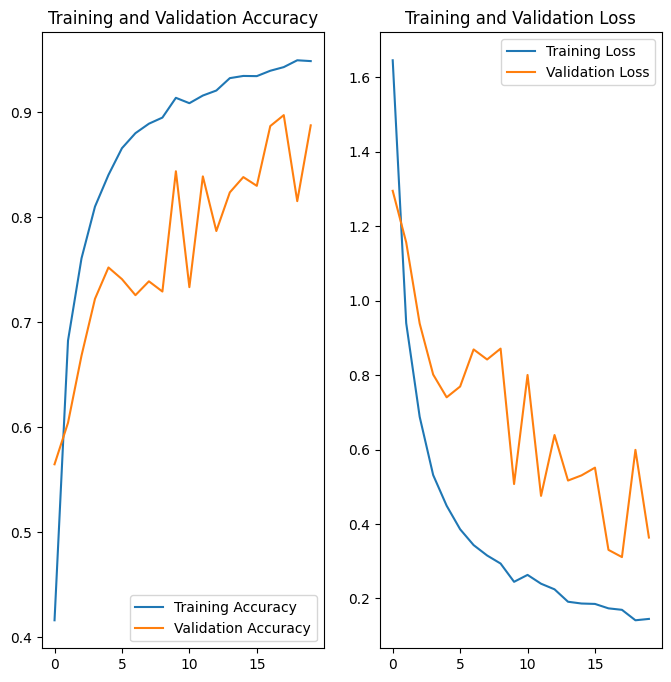

In [22]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### **Running prediction on a sample image**

In [9]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
   
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    break

NameError: name 'test_ds' is not defined

### **Predictions**

In [24]:
def predict_tomato_diseases(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
  

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 47ms/step


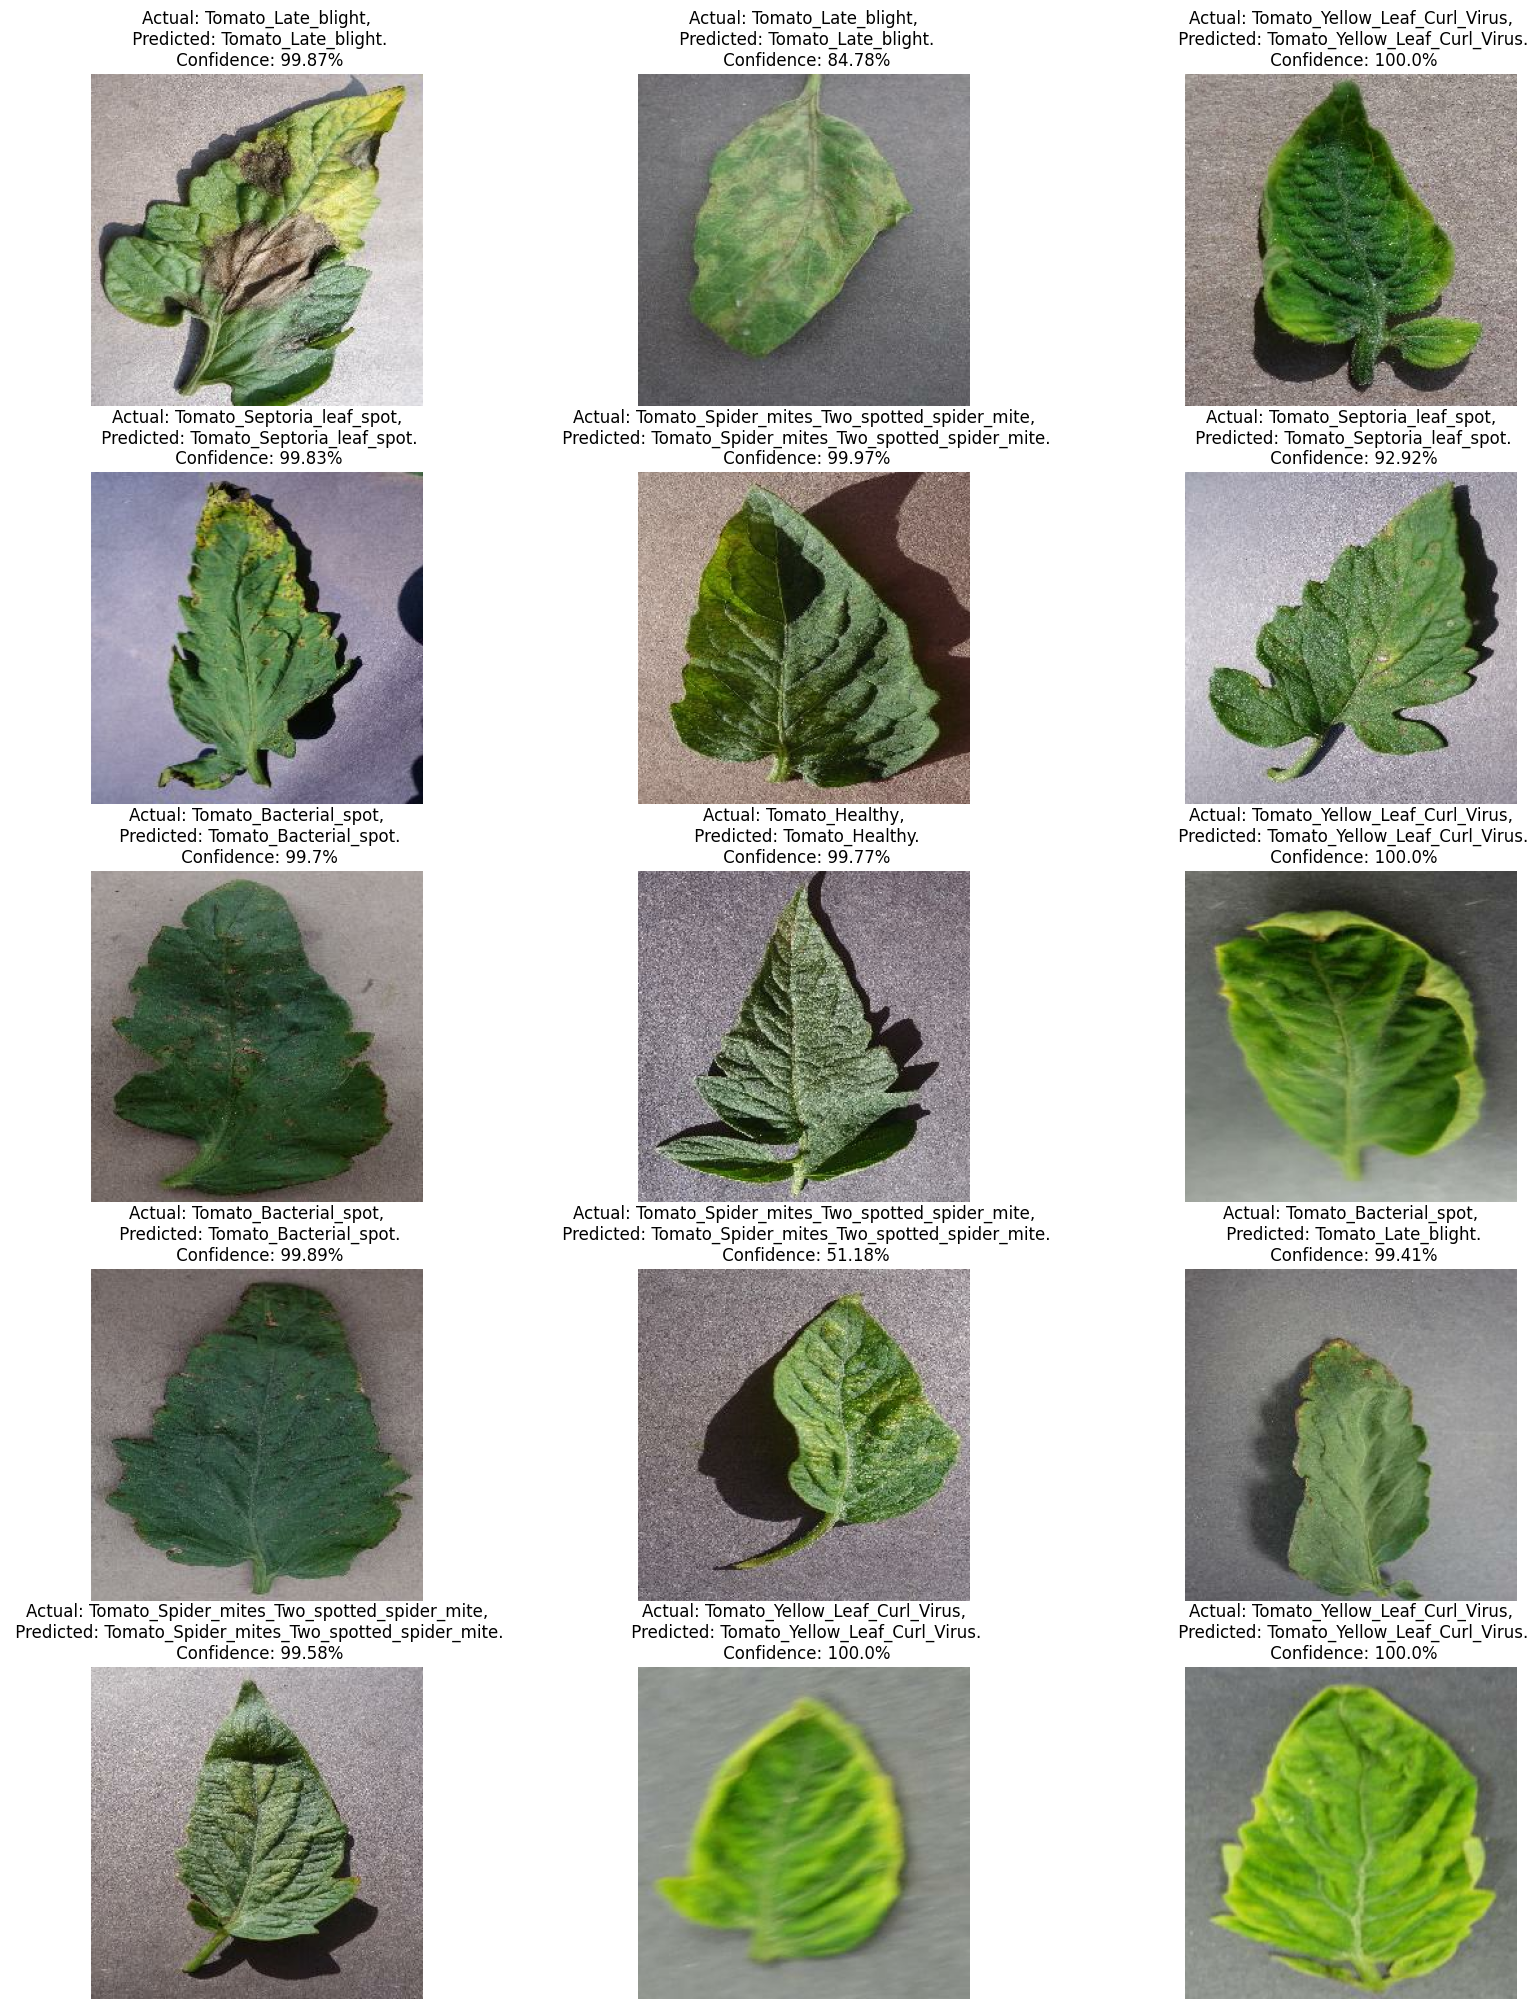

In [28]:
plt.figure(figsize=(20, 25))
for images, labels in test_ds.take(1):
    for i in range(15):
        ax = plt.subplot(5, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict_tomato_diseases(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

### **Save Model**

In [7]:
!mkdir models
import os
model_version=max([int(i) for i in os.listdir("models") + [0]])+1
model.save(f"models/tomato_{model_version}")

A subdirectory or file models already exists.


NameError: name 'model' is not defined

In [8]:
model.save("tomato.h5")

NameError: name 'model' is not defined

In [5]:
os.chdir(r'')

from IPython.display import FileLink
FileLink(r'tomato.h5')

OSError: [WinError 123] The filename, directory name, or volume label syntax is incorrect: ''

In [6]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

ValueError: invalid literal for int() with base 10: 'tomato.h5'

#### **Selesai :)**